Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Epoch 1/1000
4/4 [==============================] - 4s 144ms/step - loss: 8.0076 - accuracy: 0.1273 - val_loss: 7.9050 - val_accuracy: 0.1622
Epoch 2/1000
4/4 [==============================] - 0s 31ms/step - loss: 7.8586 - accuracy: 0.1227 - val_loss: 7.7628 - val_accuracy: 0.1486
Epoch 3/1000
4/4 [==============================] - 0s 25ms/step - loss: 7.7259 - accuracy: 0.1227 - val_loss: 7.6246 - val_accuracy: 0.1622
Epoch 4/1000
4/4 [==============================] - 0s 23ms/step - loss: 7.5840 - accuracy: 0.1000 - val_loss: 7.4897 - val_accuracy: 0.1351
Epoch 5/1000
4/4 [==============================] - 0s 24ms/step - loss: 7.4474 - accuracy: 0.1636 - val_loss: 7.3586 - val_accuracy: 0.1622
Epoch 6/1000
4/4 [==============================] - 0s 30ms/step - loss: 7.3206 - accuracy: 0.1045 - val_loss: 7.2306 - val_accuracy: 0.1757
Epoch 7/1000
4/4 [==============================] - 0s 26ms/step - loss: 7.1943 - accuracy: 0.1000 - val_loss: 7.1056 - val_accuracy: 0.1757
Epoch 8/1000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 0s 5ms/step - loss: 1.0394 - accuracy: 0.9324
Test Loss: 1.0394147634506226
Test Accuracy: 0.9324324131011963


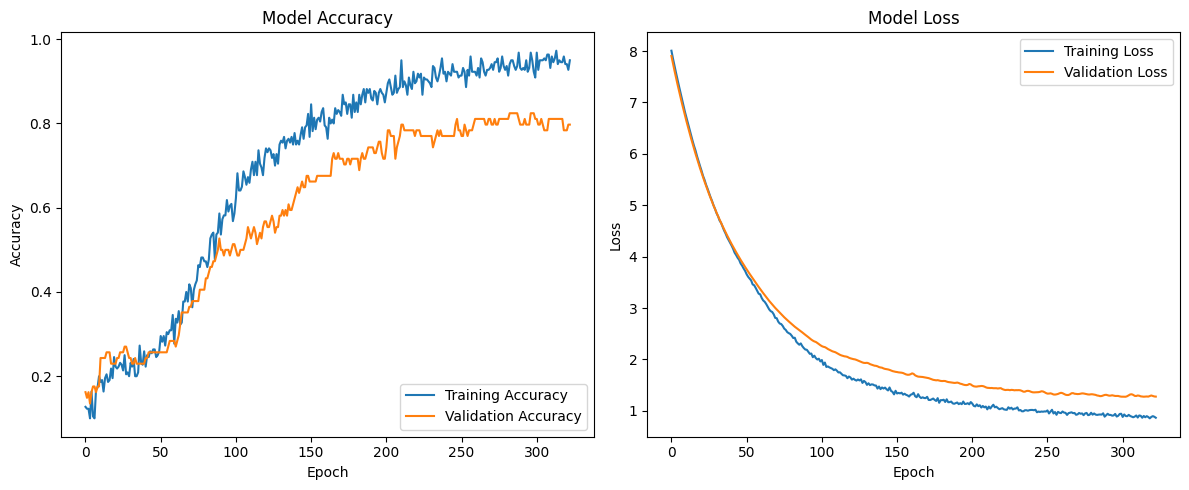

3/3 [==============================] - 0s 5ms/step


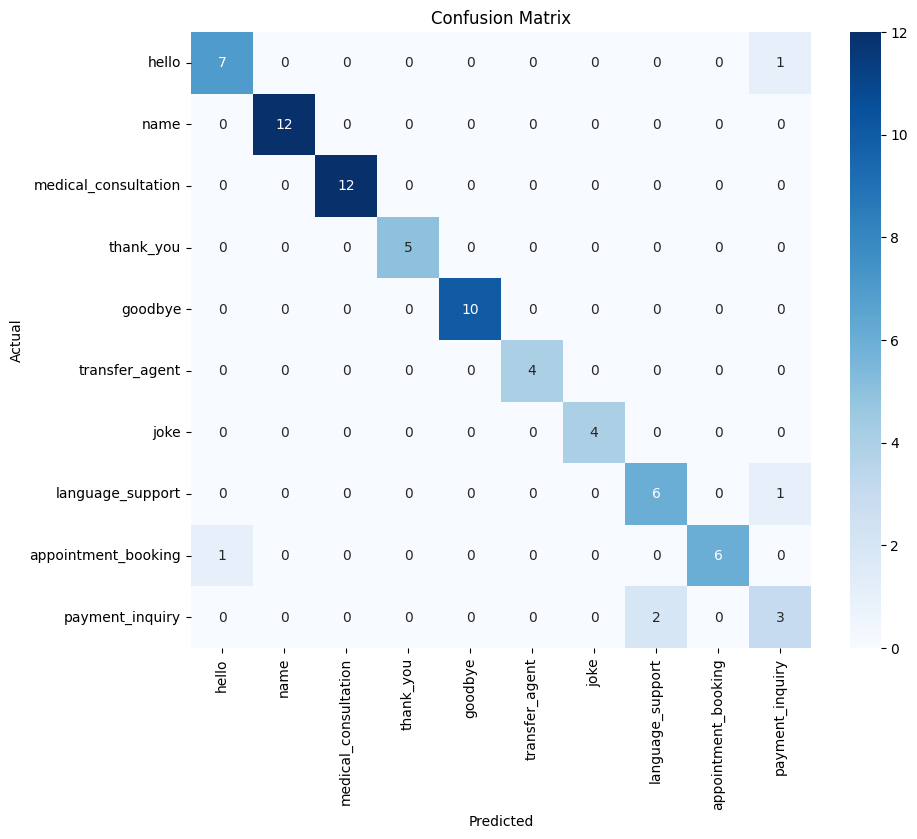

                      precision    recall  f1-score   support

               hello       0.88      0.88      0.88         8
                name       1.00      1.00      1.00        12
medical_consultation       1.00      1.00      1.00        12
           thank_you       1.00      1.00      1.00         5
             goodbye       1.00      1.00      1.00        10
      transfer_agent       1.00      1.00      1.00         4
                joke       1.00      1.00      1.00         4
    language_support       0.75      0.86      0.80         7
 appointment_booking       1.00      0.86      0.92         7
     payment_inquiry       0.60      0.60      0.60         5

            accuracy                           0.93        74
           macro avg       0.92      0.92      0.92        74
        weighted avg       0.94      0.93      0.93        74



In [40]:
import random
import json
import pickle
import numpy as np
import tensorflow as tf
from tensorflow.keras.regularizers import l2

import nltk
from nltk.stem import WordNetLemmatizer # To convert words to their root form

'''For creating the neural network'''
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split

'Set the random seed for reproducibility'
SEED = 5
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

lemmatizer = WordNetLemmatizer()

from google.colab import drive
drive.mount('/content/drive')
intents = json.loads(open('/content/drive/MyDrive/augmented_intents.json').read())

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

words = []
classes = []
documents = []
ignore_letters = ['?','!','¡','¿','.',',',':',';','/','|','-','+','@','%']

'''Classify patterns and categories'''
for intent in intents['intents']:
    for pattern in intent['patterns']:
        word_list = nltk.word_tokenize(pattern)
        words.extend(word_list)
        documents.append((word_list, intent['tag']))
        if intent['tag'] not in classes:
            classes.append(intent['tag'])

words = [lemmatizer.lemmatize(word) for word in words if word not in ignore_letters]
words = sorted(set(words))

pickle.dump(words, open('words.pkl', 'wb'))
pickle.dump(classes, open('classes.pkl', 'wb'))

'''It passes the information to ones or zeros, the according with the words in each category to make the train'''
training = []
test_x = []
test_y = []
output_empty = [0]*len(classes)

for document in documents:
    bag = []
    word_patterns = document[0]
    word_patterns = [lemmatizer.lemmatize(word.lower()) for word in word_patterns]
    for word in words:
        bag.append(1) if word in word_patterns else bag.append(0)
    output_row = list(output_empty)
    output_row[classes.index(document[1])] = 1
    training.append([bag, output_row])
    test_x.append(bag)
    test_y.append(output_row)

# Shuffle the training data
# random.shuffle(training)
# training = np.array(training, dtype=object)
# print(training)

'''Split the data into training and testing sets'''
train_x, test_x, train_y, test_y = train_test_split(
    np.array([i[0] for i in training]),
    np.array([i[1] for i in training]),
    test_size=0.2,  # 80% training, 20% testing
    random_state=5
)

'''Further split the training data into training and validation sets'''
train_x, valid_x, train_y, valid_y = train_test_split(
    train_x,
    train_y,
    test_size=0.25,  # 60% training, 20% validation
    random_state=5
)

'''Creating the neural network '''
model = Sequential()
model.add(Dense(256, input_shape=(len(train_x[0]),), activation='relu', kernel_regularizer=l2(0.01)))       # neurons
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))                                       # layers
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))                                        # layers
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))                                        # layers
model.add(Dropout(0.2))
# model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))                                        # layers
# model.add(Dropout(0.2))
model.add(Dense(len(train_y[0]), activation='softmax'))

'''Creating the optimizer and compile it'''
optimizer = Adam(learning_rate=0.0003, weight_decay = 0.001)
model.compile(loss='categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)

'''Training the model and save it'''
train_process = model.fit(
    train_x,
    train_y,
    epochs=1000,
    batch_size=64,
    verbose=1,
    validation_data=(valid_x, valid_y),
    callbacks=[early_stopping],
    shuffle=False
)
# model.save("chatbot_seq_bow.h5", train_process)

'''testing the model
Also, it is essential to evaluate the model's performance on a separate test set to get a better understanding of its generalization capabilities
'''
''' Train set'''
train_loss, train_accuracy = model.evaluate(train_x, train_y)

print("Train Loss:", train_loss)
print("Train Accuracy:", train_accuracy)

''' Test set'''
test_loss, test_accuracy = model.evaluate(test_x, test_y)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

import matplotlib.pyplot as plt

# Extracting the training history
history = train_process.history

# Plotting the training and validation accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend(loc='lower right')

# Plotting the training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Predict the labels for the test set
y_pred = model.predict(test_x)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_y, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

report = classification_report(y_true, y_pred_classes, target_names=classes)
print(report)
